# Tensorflow Core Learning Algorithms 1

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [3]:
print(tf.__version__)

2.15.0


We will walk through 4 fundamental machine learning algorithms and apply each to unique problems and datasets. The algorithms we will focos on are:
- Linear Regression
- Classification
- Clustering
- Hidden Markov Models

Many tools within TensorFlow that could be used to solve the problems we will see below. The tools chosen give the most variety and are easiest to use.


## Linear Regression
The most basic forms of machine learning and is used to predict numeric values. We will use linear regression to predict the survival rate of passangers from the titanic dataset.

### Idea of Linear Regression
Consider the following figure

(0.0, 6.0, 0.0, 20.0)

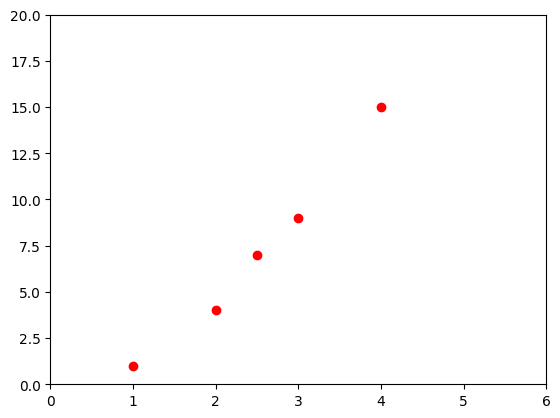

In [4]:
x = [1, 2, 2.5, 3, 4] # defining a list
y = [1, 4, 7, 9, 15] # defining a list
plt.plot(x, y, 'ro') # plotting x against y
plt.axis([0, 6, 0, 20]) # focusing the frame of the plot on [0, 6] for the x-axis and [0, 20] for the y-axis

We can see the points above has a linear correspondence. We see that as x increases, so does y. Because of this relation, we can create a line of best fit for this dataset. In this example our line will only use one input variable, as we are working with two dimensions. In larger datasets, it will have more features and inputs.

Hence the idea of linear regression is:

**Finding the line of best fit which is a line through a scatter plot of data points that best expresses the relationship between those points.**

Here is the equation of a line in 2D:
$$y = mx + b$$

For the scatterplot above, here's an example of a line of best fit.

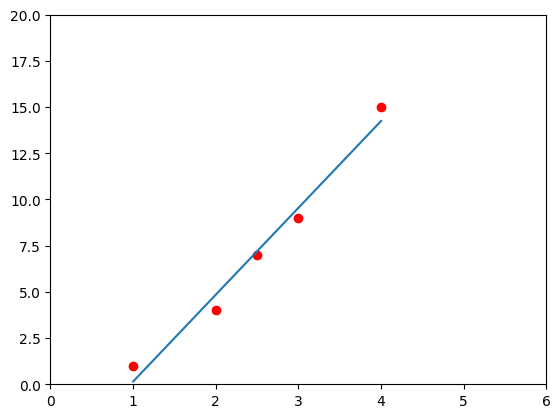

In [5]:
plt.plot(x, y, 'ro') 
plt.axis([0, 6, 0, 20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x))) # ???
plt.show() # this is actually not necessary if we are working in an interactive environment like notebook

The blue line is the line of best fit and can be used to predict future values.

Remark: The mathematics behind linear regression is by minimizing the squared residuals with the line, which has a closed form. But, in this tutorial, we use the "gradient descent" approach because of computational cost (time complexity and memory complexity).

### Data
We will use the titanic dataset. It has tons of information about each passanger on the ship. The first step is always to understand the data and explore it.

We load the data set and explore it using some built-in tools below.

In [6]:
# Load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

The `pd.read_csv()` method will return us a new pandas dataframe (like a table).

Initially, `dftrain` includes the 'survived' column, but after applying `.pop('survived')` to it and assign it to `y_train`, what happened is we removed the 'survived' column from `dftrain` and move it to `y_train`. From here on, `dftrain` does not have the 'survived' column. Same process applies for `y_eval`.

We can use `.head()` to view the first 5 rows of the dataframe.

In [7]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [8]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [9]:
print(dftrain.loc[0], y_train.loc[0])

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


`.loc[i]` method gives the information of the row i.

In [10]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


`.describe()` method gives more statistical analysis.

In [11]:
dftrain.shape

(627, 9)

It tells us we have 627 entries/observations and 9 features.

Now, lets look at the survival information.

In [12]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

We see that each entry is either 0 (no) or 1 (yes).

It is worth to visualize a few graphs of the data.

<Axes: >

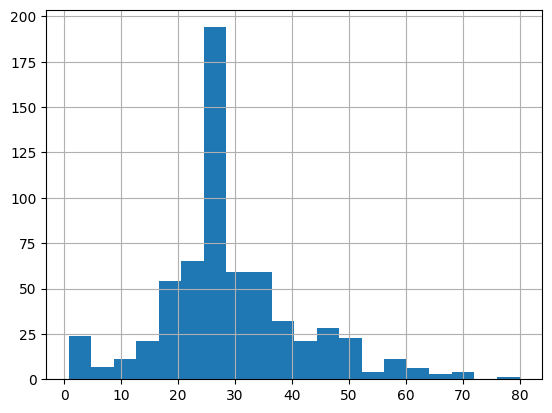

In [13]:
dftrain.age.hist(bins=20) # we divide the range of the age into 20 intervals

<Axes: ylabel='sex'>

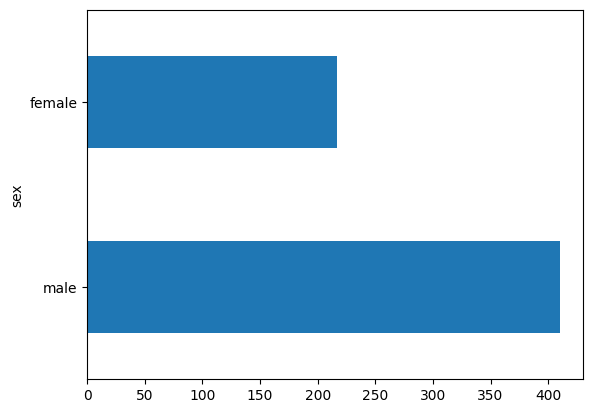

In [14]:
dftrain.sex.value_counts().plot(kind='barh') # barh means bar graph

<Axes: ylabel='class'>

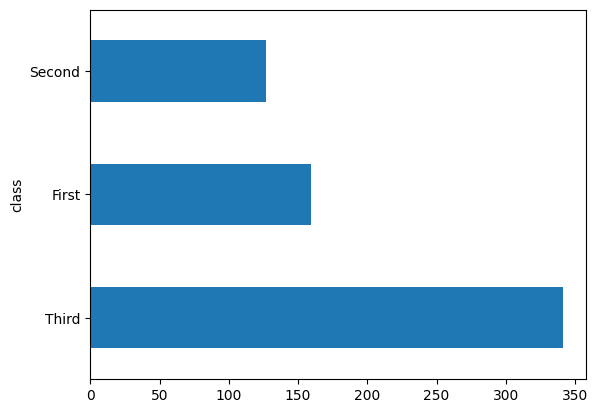

In [15]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

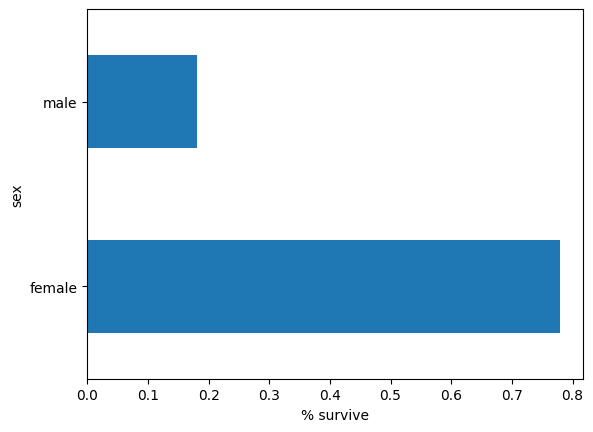

In [16]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

`pd.concat` method stacks the dataframes, set axis=0 (default) to stack vertically, set axis=1 to stack horizonyally.

`.groupby()` method splits the data into groups

After analyzing this information, we should notice the following:
- The majority of the passengers are in their 20's or 30's
- The majority of passengers are male
- The majority of passengers are in "Third" class
- Females have a much higher chance of survival

### Training vs Testing Data
When we train models, we need two sets of data: **training** and **testing**.

The **training** data is what we feed to the model so it can develop and learn, which is usually much larger size than the testing data.

The **testing** data is what we use to evaluate model and see how it performs. We must use a seperate set of data that the model has not been trained on to evaluate it.

The point of our model is to make **predictions** on NEW data.

### Feature Columns
In our dataset, we have two different kinds of information: **Categorical** and **Numeric**

Before we continue, we must convert our categorical data into numeric data. We can do this by encoding each category with an integer (ex. male = 1, female = 2).

In [17]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

CATEGORICAL_COlUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']

NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []

for feature_name in CATEGORICAL_COlUMNS:
    vocabulary = dftrain[feature_name].unique() # given a feature column, get a list of all unique values in that column
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', 

The code above is basically declaring what kind of value that each feature column can take? while also creating columns?

### The Training Process
For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries, because we can't load large dataset at once into RAM. We will actually feed these batches to our model multiple times according to the number of **epochs**.

An **epoch** is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset but in a different order. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it. Overfitting would happen if we put large value of epochs.

Ex. if we have 10 epochs, our model will see the same dataset 10 times.

Since we need to feed our data in batches and multiple times we need to create something called an **input function**. The input function simply defines how our dataset will be converted into batches at each epoch.

### Input Function
The TensorFlow model we are going to use requires that the data we pass it comes in as a `tf.data.Dataset` object. This means we must create an *input function* that can convert our current pandas dataframe into that object.

Below you'll see a seemingly complicated input function, this is straight form the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear).

In [18]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function(): # inner function, this will be returned
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # create tf.data.Dataset object with data and its label
        if shuffle:
            ds = ds.shuffle(1000) # randomize order of data
        ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into batches of 32 and repeat process for number of epochs
        return ds # return a batch of the dataset
    return input_function # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train) # here we will call the input_function that was returned to us to get a dataset object we can
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

The inner function is necessary because the estimator requires a function that returns a data set. So, each time the estimator calls the function, it will create a new dataset? If we return dataset without inner function, then the estimator will always use the same dataset?

### Creating the Model
In this tutorial, we are going to use a linear estimator to utilize the linear regression algorithm.

In [19]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimator by passing the feature columns we created earlier

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/3q/7940jm5955s9rqks86c04zcc0000gn/T/tmpnuozthq2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'wor

The code above is to create the model. We use LinearClassifier since the target variable (y values) is discrete. One uses LinearRegressor if the target variable is continuous.

### Training the Model
Passing the input functions we created earlier.

In [20]:
linear_est.train(train_input_fn) # train
result = linear_est.evaluate(eval_input_fn) # get model metrics/stats by testing on tsting data

clear_output() # clears console output
print(result['accuracy']) # the result variable is simply a dict of stats about our model
print(result)

0.7386364
{'accuracy': 0.7386364, 'accuracy_baseline': 0.625, 'auc': 0.8315274, 'auc_precision_recall': 0.7925658, 'average_loss': 0.48474452, 'label/mean': 0.375, 'loss': 0.47923523, 'precision': 0.6442308, 'prediction/mean': 0.41901827, 'recall': 0.67676765, 'global_step': 200}


In [21]:
result = list(linear_est.predict(eval_input_fn))
k=8
print(dfeval.loc[k])
print(y_eval[k])
print(result[k]['probabilities'][1])

INFO:tensorflow:Calling model_fn.


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/3q/7940jm5955s9rqks86c04zcc0000gn/T/tmpnuozthq2/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
sex                        female
age                          18.0
n_siblings_spouses              2
parch                           0
fare                         18.0
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 8, dtype: object
0
0.6269242


The model predicts 62% of survival but the actual observation is that the person did not survive.